## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


Import libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import layers

Starter code

In [4]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [5]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [6]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

##tissue_pixels = find_tissue_pixels(slide_image)
#print(tissue_pixels)
#percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
#print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

#tissue_regions = apply_mask(slide_image, tissue_pixels)
#plt.imshow(tissue_regions)

Connect to Google Drive to access the tif files

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


Store the file paths we use for training.
Then show some tumor images and mask images as sanity check.

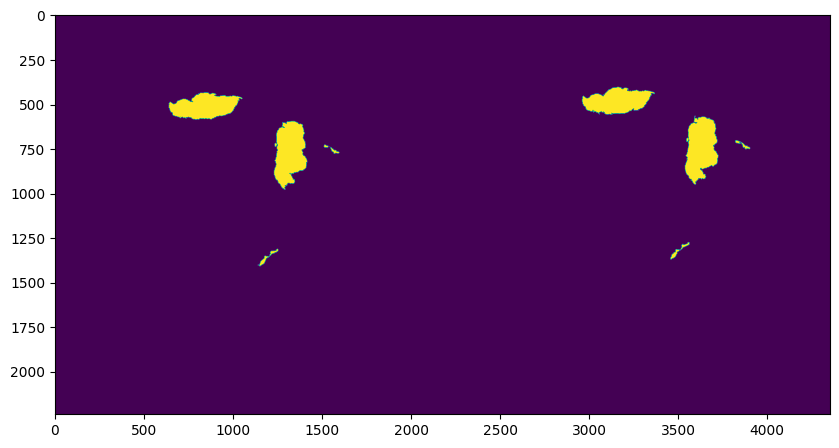

In [8]:
root_dir = '/gdrive/MyDrive/slide_dataset/'
train_file_name = [
                   "tumor_064.tif", "tumor_075.tif", "tumor_078.tif", 
                   "tumor_084.tif", "tumor_091.tif", "tumor_101.tif"]
mask_file_name = [x[0:9]+"_mask.tif" for x in train_file_name]
slide1 = open_slide(root_dir+mask_file_name[5])

image2 = read_slide(slide1, x=0, y=0, level=5,  width=slide1.level_dimensions[5][0], 
                     height=slide1.level_dimensions[5][1])[:,:,0]
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(image2)

# Model of zoom level 3

We first create a model to draw heatmaps based on the training data from a single zoom level, level 5. 

Create a function to extract patches from images of zoom level 5 and label them by determining whether the center region of patches contain cancer cells.



In [9]:
dataset = []
def create_dataset_from_tif(tumor_name, mask_name, level, dataset, length):
  slide_t = open_slide(tumor_name)
  slide_m = open_slide(mask_name)
  width = slide_t.level_dimensions[level][0]
  height = slide_t.level_dimensions[level][1]
  col = int(width /length) - 1
  row = int(height / length) - 1
  for i in range(2*col):
    for j in range(2*row):
      if length//2*i + length*2 > width or length//2*j + length*2 > height: break
      x_m = length//2+length//2*i
      y_m = length//2+length//2*j
      patch = read_slide(slide_t, x = length//2*i*np.int(slide_t.level_downsamples[level]), y = length//2*j*np.int(slide_t.level_downsamples[level]), level = level,
                         width = length*2, height = length*2)
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
      if percent_tissue <20 : continue
      mask = read_slide(slide_m, x = x_m*np.int(slide_t.level_downsamples[level]), y = y_m*np.int(slide_t.level_downsamples[level]), level = level,
                         width = length, height = length)[:,:,0]
      #print(mask)
      summ = 0
      for x in mask:
        for y in x:
          summ = summ + y
      if summ > length^2 // 2:
        dataset.append((patch, 1))
      else:
        x = random.random()
        if x < 0.3: dataset.append((patch, 0))

for i in range(6):
  create_dataset_from_tif(root_dir+train_file_name[i], root_dir+mask_file_name[i], 3, dataset, 64)


      




Check the total number of patches and the number of patches with cancer cells.
Show an image as sanity check.

total number of patches is: 74018
number of patches with cancer cells is 28533


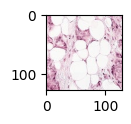

In [10]:
print("total number of patches is: " + str(len(dataset)))
cancer = 0
noncancer = 0
for data in dataset:
  if data[1] == 1:
    cancer += 1
  if data[1] == 0:
    noncancer += 1
print("number of patches with cancer cells is " + str(cancer))
plt.figure(figsize=(1, 1), dpi=100)
plt.imshow(dataset[1800][0])

Shuffle the dataset. There are far more images without cancer cells than images with cancer cells. Therefore, we need to balance the dataset. We keep all images with cancer cells and only keep the same number of images without cancer cells.

In [11]:
random.shuffle(dataset)
noncancer_l = []
cancer_l = []
for data in dataset:
  if data[1] == 0:
    noncancer_l.append(data)
  if len(noncancer_l) >= cancer: break

for data in dataset:
  if data[1] == 1:
    cancer_l.append(data)

dataset = noncancer_l+cancer_l
random.shuffle(dataset)

print(len(noncancer_l))



28533


Extract some image label pair as test dataset.

In [12]:
test_set = dataset[:200]
train_set = dataset[200:]

In [13]:
print(len(train_set))

56866


Split training dataset into training dataset and validation dataset randomly.

In [14]:
x = np.array([row[0] for row in train_set])
y = np.array([row[1] for row in train_set])
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
X_test = np.array([row[0] for row in test_set])
y_test = np.array([row[1] for row in test_set])
print(sum(y_test))

92


Show some images and their labels as sanity check. We can see that the dataset is balanced.

The percentage of yes answer is: 0.49962630792227203 in training set
The percentage of yes answer is: 0.5021979954281696 in validation set


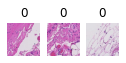

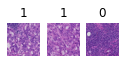

In [16]:
plt.figure(figsize=(2, 2))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis("off")

plt.figure(figsize=(2,2))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_val[i])
  plt.title(y_val[i])
  plt.axis("off")

print("The percentage of yes answer is: " + str(sum(y_train)/len(y_train)) 
  + " in training set")
print("The percentage of yes answer is: " + str(sum(y_val)/len(y_val)) 
  + " in validation set")

Create tensorflow datasets for training set, validation set and test set

In [17]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y_train, tf.int64))
image_ds = tf.data.Dataset.from_tensor_slices(X_train)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)


  

0 (128, 128, 3)
1 (128, 128, 3)
2 (128, 128, 3)
3 (128, 128, 3)


In [18]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((128, 128, 3), ()), types: (tf.uint8, tf.int64)>


In [19]:
SHUFFLE_SIZE = 1000
BATCH_SIZE = 32

In [20]:
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
image_ds_v = tf.data.Dataset.from_tensor_slices(X_val)
label_ds_v = tf.data.Dataset.from_tensor_slices(tf.cast(y_val, tf.int64))
image_label_ds_v = tf.data.Dataset.zip((image_ds_v, label_ds_v))
val_ds = image_label_ds_v.cache().batch(BATCH_SIZE)

In [22]:
image_ds_t = tf.data.Dataset.from_tensor_slices(X_test)
label_ds_t = tf.data.Dataset.from_tensor_slices(tf.cast(y_test, tf.int64))
image_label_ds_t = tf.data.Dataset.zip((image_ds_t, label_ds_t))
test_ds = image_label_ds_t.cache().batch(BATCH_SIZE)

Data augmentation to improve accuracy. We may not use it in the first model as the patches are too small. We use it in other models.

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

In [25]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


Create the model, compile it and fit it using datasets.

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=(128, 128, 3))
#x = data_augmentation(inputs)
x = rescale(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
1422/1422 [==============================] - 43s 25ms/step - loss: 0.1671 - accuracy: 0.9326 - val_loss: 0.0626 - val_accuracy: 0.9745
Epoch 2/10
1422/1422 [==============================] - 33s 23ms/step - loss: 0.0665 - accuracy: 0.9752 - val_loss: 0.0744 - val_accuracy: 0.9704
Epoch 3/10
1422/1422 [==============================] - 33s 23ms/step - loss: 0.0510 - accuracy: 0.9823 - val_loss: 0.0438 - val_accuracy: 0.9851
Epoch 4/10
1422/1422 [==============================] - 33s 23ms/step - loss: 0.0415 - accuracy: 0.9861 - val_loss: 0.0549 - val_accuracy: 0.9837
Epoch 5/10
1422/1422 [==============================] - 33s 23ms/step - loss: 0.0396 - accuracy: 0.9859 - val_loss: 0.0972 - val_accuracy: 0.9735
Epoch 6/10
1422/1422 [==============================] - 33s 23ms/step - loss: 0.0324 - accuracy: 0.9887 - val_loss: 0.0478 - val_accuracy: 0.9873
Epoch 7/10
1422/1422 [==============================] - 33s 23ms/step - loss: 0.0268 - accuracy: 0.9903 - val_loss: 0.0741 -

Check how many images the model can predict correctly. (It takes long time to run so I commented it out.

In [31]:
model.save("/content/model_level_3.h5")

In [32]:
"""
count1 = 0
for data in train_set:
  if data[1] == 1:
    count1+=1
print("number of cancer in dataset: " + str(count1))
count2 = 0
for data in train_set:
  im_batch = tf.expand_dims(data[0]/255.0,0)
  prediction = model.predict(im_batch)
  predict = 1
  if prediction[0][0] < 0:
    predict = 0
  #predictions = batch_pred[0]
  #predictions = tf.nn.sigmoid(predictions)
  #predictions = tf.where(predictions < 0.5, 0, 1)
  #prediction = predictions[0].numpy()
  if predict == data[1]:
    count2 += 1
print("number of correct prediction in dataset: " + str(count2))
"""

'\ncount1 = 0\nfor data in train_set:\n  if data[1] == 1:\n    count1+=1\nprint("number of cancer in dataset: " + str(count1))\ncount2 = 0\nfor data in train_set:\n  im_batch = tf.expand_dims(data[0]/255.0,0)\n  prediction = model.predict(im_batch)\n  predict = 1\n  if prediction[0][0] < 0:\n    predict = 0\n  #predictions = batch_pred[0]\n  #predictions = tf.nn.sigmoid(predictions)\n  #predictions = tf.where(predictions < 0.5, 0, 1)\n  #prediction = predictions[0].numpy()\n  if predict == data[1]:\n    count2 += 1\nprint("number of correct prediction in dataset: " + str(count2))\n'

In [33]:
im_batch = tf.expand_dims(train_set[0][0],0)
print(model.predict(im_batch))

[[13.706594]]


Evaluate the model on the testing dataset.

In [34]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

7/7 [==============================] - 0s 25ms/step - loss: 0.0524 - accuracy: 0.9850
Test accuracy : 0.9850000143051147


In [35]:
print(len(train_set))

56866


Create a function to draw heat map given a tumor image. It uses a single zoom level for now.

In [36]:
def draw_heat_map(tumor_name, level, model, length):
  slide = open_slide(tumor_name)
  width = slide.level_dimensions[level][0]
  height = slide.level_dimensions[level][1]
  col = int(width/length) - 1
  row = int(height/length) - 1
  mask = np.zeros((height, width))
  for i in range(col):
    for j in range(row):
      x_m = length//2+length*i
      y_m = length//2+length*j
      patch = read_slide(slide, x = length*i*np.int(slide.level_downsamples[level]), y = length*j*np.int(slide.level_downsamples[level]), level = level,
                         width = length*2, height = length*2)
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
      if percent_tissue <20 : continue
      im_batch = (tf.expand_dims(patch,0)) 
      batch_pred = model.predict(im_batch)
      predictions = batch_pred[0]
      predictions = tf.nn.sigmoid(predictions)
      predictions = tf.where(predictions < 0.5, 0, 1)
      prediction = predictions[0].numpy()
     # print(prediction)
      if prediction == 1:
        for m in range(x_m, x_m + length):
          for n in range(y_m, y_m + length):
            mask[n][m] = 1
  return mask

Draw a heat map for one tumor image. As we can see the model outlines the region of cancer cells but it is not accurate enought. We will combine the predictions of other models in the following sections.

In [37]:
themask = draw_heat_map(root_dir+"tumor_110.tif", 3, model, 64)

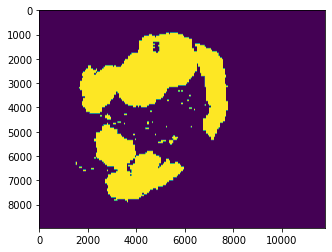

In [38]:
plt.imshow(themask)

Show the original heatmap to compare.

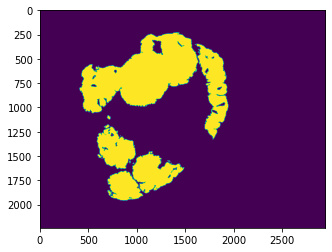

In [39]:
masks = open_slide(root_dir+"tumor_110_mask.tif")
mask_image1 = read_slide(masks, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=masks.level_dimensions[5][0], 
                        height=masks.level_dimensions[5][1])[:,:,0]
plt.imshow(mask_image1)

# Model of zoom level 4

Same as above. Create the dataset for images of zoom level 6.

In [41]:
dataset1 = []
def create_dataset_from_tif1(tumor_name, mask_name, level, dataset, length):
  slide_t = open_slide(tumor_name)
  slide_m = open_slide(mask_name)
  width = slide_t.level_dimensions[level][0]
  height = slide_t.level_dimensions[level][1]
  col = int(width /length) - 2
  row = int(height / length) - 2
  for i in range(col):
    for j in range(row):
      if length*i+length*4 > width or length*j+length*4 > height: break
      x_m = int(length*1.5)+length*i
      y_m = int(length*1.5)+length*j
      patch = read_slide(slide_t, x = length*i*np.int(slide_t.level_downsamples[level]), y = length*j*np.int(slide_t.level_downsamples[level]), level = level,
                         width = length*4, height = length*4)
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
      if percent_tissue <35 : continue
      mask = read_slide(slide_m, x = x_m*np.int(slide_t.level_downsamples[level]), y = y_m*np.int(slide_t.level_downsamples[level]), level = level,
                         width = length, height = length)[:,:,0]
      #print(mask)
      summ = 0
      for x in mask:
        for y in x:
          summ = summ + y
      if summ > length^2 // 2:
        dataset.append((patch, 1))
      else:
        x = random.random()
        if x < 0.3: dataset.append((patch, 0))

for i in range(4):
  create_dataset_from_tif1(root_dir+train_file_name[i], root_dir+mask_file_name[i], 4, dataset1, 32)

total number of patches is: 11502
number of patches with cancer cells is 5698


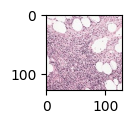

In [42]:
print("total number of patches is: " + str(len(dataset1)))
cancer1 = 0
noncancer1 = 0
for data in dataset1:
  if data[1] == 1:
    cancer1 += 1
  if data[1] == 0:
    noncancer1 += 1
print("number of patches with cancer cells is " + str(cancer1))
plt.figure(figsize=(1, 1), dpi=100)
plt.imshow(dataset1[200][0])

In [43]:
random.shuffle(dataset1)
noncancer_l1 = []
cancer_l1 = []
for data in dataset1:
  if data[1] == 0:
    noncancer_l1.append(data)
  if len(noncancer_l1) >= cancer1: break

for data in dataset1:
  if data[1] == 1:
    cancer_l1.append(data)

dataset1 = noncancer_l1+cancer_l1
random.shuffle(dataset1)

print(len(noncancer_l1))



5698


In [44]:
test_set1 = dataset1[:100]
train_set1 = dataset1[100:]

In [45]:
x1 = np.array([row[0] for row in train_set1])
y1 = np.array([row[1] for row in train_set1])
X_train1, X_val1, y_train1, y_val1 = train_test_split(x1, y1, test_size=0.2, random_state=42)

In [46]:
X_test1 = np.array([row[0] for row in test_set1])
y_test1 = np.array([row[1] for row in test_set1])
print(sum(y_test1))

50


The percentage of yes answer is: 0.5002213368747234 in training set
The percentage of yes answer is: 0.49911504424778763 in validation set


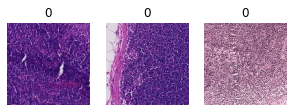

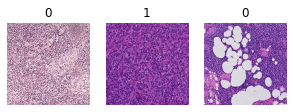

In [47]:
plt.figure(figsize=(5, 5))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_train1[i])
  plt.title(y_train1[i])
  plt.axis("off")

plt.figure(figsize=(5,5))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_val1[i])
  plt.title(y_val1[i])
  plt.axis("off")

print("The percentage of yes answer is: " + str(sum(y_train1)/len(y_train1)) 
  + " in training set")
print("The percentage of yes answer is: " + str(sum(y_val1)/len(y_val1)) 
  + " in validation set")

In [48]:
label_ds1 = tf.data.Dataset.from_tensor_slices(tf.cast(y_train1, tf.int64))
image_ds1 = tf.data.Dataset.from_tensor_slices(X_train1)
for n, image in enumerate(image_ds1.take(4)):
  print(n, image.shape)


  

0 (128, 128, 3)
1 (128, 128, 3)
2 (128, 128, 3)
3 (128, 128, 3)


In [49]:
image_label_ds1 = tf.data.Dataset.zip((image_ds1, label_ds1))
print(image_label_ds1)

<ZipDataset shapes: ((128, 128, 3), ()), types: (tf.uint8, tf.int64)>


In [50]:
train_ds1 = image_label_ds1.cache()
train_ds1 = train_ds1.shuffle(SHUFFLE_SIZE)
train_ds1 = train_ds1.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [51]:
image_ds_v1 = tf.data.Dataset.from_tensor_slices(X_val1)
label_ds_v1 = tf.data.Dataset.from_tensor_slices(tf.cast(y_val1, tf.int64))
image_label_ds_v1 = tf.data.Dataset.zip((image_ds_v1, label_ds_v1))
val_ds1 = image_label_ds_v1.cache().batch(BATCH_SIZE)

In [52]:
image_ds_t1 = tf.data.Dataset.from_tensor_slices(X_test1)
label_ds_t1 = tf.data.Dataset.from_tensor_slices(tf.cast(y_test1, tf.int64))
image_label_ds_t1 = tf.data.Dataset.zip((image_ds_t1, label_ds_t1))
test_ds1 = image_label_ds_t1.cache().batch(BATCH_SIZE)

In [53]:
base_model1 = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

In [54]:
base_model1.trainable = True

In [55]:
print("Number of layers in the base model: ", len(base_model1.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [56]:
global_average_layer1 = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer1 = tf.keras.layers.Dense(1)
inputs1 = tf.keras.Input(shape=(128, 128, 3))
y = data_augmentation(inputs1)
y = rescale(y)
y = base_model1(inputs1, training=False)
y = global_average_layer1(y)
y = tf.keras.layers.Dropout(0.2)(y)
outputs1 = prediction_layer1(y)
model1 = tf.keras.Model(inputs1, outputs1)

In [57]:
model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model1.fit(train_ds1, validation_data=val_ds1, epochs=10)

Epoch 1/10
283/283 [==============================] - 13s 29ms/step - loss: 0.5037 - accuracy: 0.7554 - val_loss: 0.2729 - val_accuracy: 0.9018
Epoch 2/10
283/283 [==============================] - 7s 25ms/step - loss: 0.2403 - accuracy: 0.9065 - val_loss: 0.2069 - val_accuracy: 0.9177
Epoch 3/10
283/283 [==============================] - 7s 25ms/step - loss: 0.2082 - accuracy: 0.9194 - val_loss: 0.1989 - val_accuracy: 0.9274
Epoch 4/10
283/283 [==============================] - 7s 25ms/step - loss: 0.1764 - accuracy: 0.9285 - val_loss: 0.1813 - val_accuracy: 0.9199
Epoch 5/10
283/283 [==============================] - 7s 25ms/step - loss: 0.1515 - accuracy: 0.9412 - val_loss: 0.1350 - val_accuracy: 0.9460
Epoch 6/10
283/283 [==============================] - 7s 25ms/step - loss: 0.1273 - accuracy: 0.9481 - val_loss: 0.1576 - val_accuracy: 0.9323
Epoch 7/10
283/283 [==============================] - 7s 25ms/step - loss: 0.1167 - accuracy: 0.9544 - val_loss: 0.1289 - val_accuracy: 0.947

In [59]:
model1.save("/content/model_level_5.h5")

In [60]:
loss, accuracy = model1.evaluate(test_ds1)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 43ms/step - loss: 0.0522 - accuracy: 0.9700
Test accuracy : 0.9700000286102295


# Model of zoom level 5

The code structure is same as above.

In [61]:
dataset2 = []
def create_dataset_from_tif2(tumor_name, mask_name, level, dataset, length):
  slide_t = open_slide(tumor_name)
  slide_m = open_slide(mask_name)
  width = slide_t.level_dimensions[level][0]
  height = slide_t.level_dimensions[level][1]
  col = int(width /length) - 2
  row = int(height / length) - 2
  for i in range(col):
    for j in range(row):
      if length*i + length*8 > width or length*j + length*8 > height: continue
      x_m = int(length*7.5)+length*i
      y_m = int(length*7.5)+length*j
      patch = read_slide(slide_t, x = length*i*np.int(slide_t.level_downsamples[level]), y = length*j*np.int(slide_t.level_downsamples[level]), level = level,
                         width = length*8, height = length*8)
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
      if percent_tissue<50: continue
      mask = read_slide(slide_m, x = x_m*np.int(slide_t.level_downsamples[level]), y = y_m*np.int(slide_t.level_downsamples[level]), level = level,
                         width = length, height = length)[:,:,0]
      #print(mask)
      summ = 0
      for x in mask:
        for y in x:
          summ = summ + y
      if summ > length^2 // 2:
        dataset.append((patch, 1))
      else:
        x = random.random()
        if x < 0.3: dataset.append((patch, 0))

for i in range(4):
  create_dataset_from_tif2(root_dir+train_file_name[i], root_dir+mask_file_name[i], 5, dataset2, 16)

total number of patches is: 9719
number of patches with cancer cells is 4996


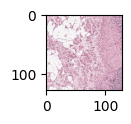

In [62]:
print("total number of patches is: " + str(len(dataset2)))
cancer2 = 0
noncancer2 = 0
for data in dataset2:
  if data[1] == 1:
    cancer2 += 1
  if data[1] == 0:
    noncancer2 += 1
print("number of patches with cancer cells is " + str(cancer2))
plt.figure(figsize=(1, 1), dpi=100)
plt.imshow(dataset2[200][0])

In [63]:
random.shuffle(dataset2)
noncancer_l2 = []
cancer_l2 = []
for data in dataset2:
  if data[1] == 0:
    noncancer_l2.append(data)
  if len(noncancer_l2) >= cancer2: break

for data in dataset2:
  if data[1] == 1:
    cancer_l2.append(data)

dataset2 = noncancer_l2+cancer_l2
random.shuffle(dataset2)

print(len(noncancer_l2))



4723


In [64]:
test_set2 = dataset2[:100]
train_set2 = dataset2[100:]

In [65]:
x2 = np.array([row[0] for row in train_set2])
y2 = np.array([row[1] for row in train_set2])
X_train2, X_val2, y_train2, y_val2 = train_test_split(x2, y2, test_size=0.2, random_state=120)

In [66]:
X_test2 = np.array([row[0] for row in test_set2])
y_test2 = np.array([row[1] for row in test_set2])
print(sum(y_test2))

56


The percentage of yes answer is: 0.5137102014294996 in training set
The percentage of yes answer is: 0.512993762993763 in validation set


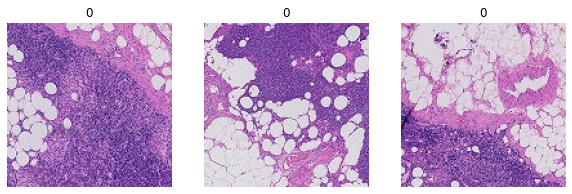

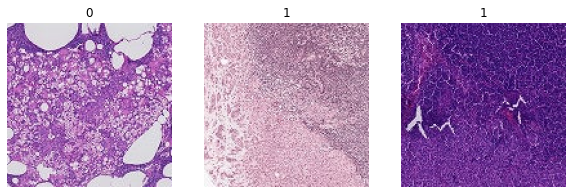

In [67]:
plt.figure(figsize=(10, 10))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_train2[i])
  plt.title(y_train2[i])
  plt.axis("off")

plt.figure(figsize=(10,10))
for i in range(3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_val2[i])
  plt.title(y_val2[i])
  plt.axis("off")

print("The percentage of yes answer is: " + str(sum(y_train2)/len(y_train2)) 
  + " in training set")
print("The percentage of yes answer is: " + str(sum(y_val2)/len(y_val2)) 
  + " in validation set")

In [68]:
label_ds2 = tf.data.Dataset.from_tensor_slices(tf.cast(y_train2, tf.int64))
image_ds2 = tf.data.Dataset.from_tensor_slices(X_train2)
for n, image in enumerate(image_ds2.take(4)):
  print(n, image.shape)


  

0 (128, 128, 3)
1 (128, 128, 3)
2 (128, 128, 3)
3 (128, 128, 3)


In [69]:
image_label_ds2 = tf.data.Dataset.zip((image_ds2, label_ds2))
print(image_label_ds2)

<ZipDataset shapes: ((128, 128, 3), ()), types: (tf.uint8, tf.int64)>


In [70]:
train_ds2 = image_label_ds2.cache()
train_ds2 = train_ds2.shuffle(SHUFFLE_SIZE)
train_ds2 = train_ds2.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [71]:
image_ds_v2 = tf.data.Dataset.from_tensor_slices(X_val2)
label_ds_v2 = tf.data.Dataset.from_tensor_slices(tf.cast(y_val2, tf.int64))
image_label_ds_v2 = tf.data.Dataset.zip((image_ds_v2, label_ds_v2))
val_ds2 = image_label_ds_v2.cache().batch(BATCH_SIZE)

In [72]:
image_ds_t2 = tf.data.Dataset.from_tensor_slices(X_test2)
label_ds_t2 = tf.data.Dataset.from_tensor_slices(tf.cast(y_test2, tf.int64))
image_label_ds_t2 = tf.data.Dataset.zip((image_ds_t2, label_ds_t2))
test_ds2 = image_label_ds_t2.cache().batch(BATCH_SIZE)

In [73]:
"""
model2 = tf.keras.Sequential([
  data_augmentation,
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(1)
])
"""

"\nmodel2 = tf.keras.Sequential([\n  data_augmentation,\n  layers.Conv2D(32, (3, 3), activation='relu'),\n  layers.MaxPooling2D((2, 2)),\n  layers.Conv2D(64, (3, 3), activation='relu'),\n  layers.MaxPooling2D((2, 2)),\n  layers.Conv2D(64, (3, 3), activation='relu'),\n  layers.Flatten(),\n  layers.Dense(32, activation='relu'),\n  layers.Dense(1)\n])\n"

In [74]:
base_model2 = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

In [75]:
base_model2.trainable = True

In [76]:
print("Number of layers in the base model: ", len(base_model2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [84]:
global_average_layer2= tf.keras.layers.GlobalAveragePooling2D()
prediction_layer2 = tf.keras.layers.Dense(1)
inputs2 = tf.keras.Input(shape=(128, 128, 3))
#z = data_augmentation(inputs2)
z = rescale(inputs2)
z = base_model2(z, training=False)
z = global_average_layer2(z)
z = tf.keras.layers.Dropout(0.2)(z)
outputs2 = prediction_layer2(z)
model2 = tf.keras.Model(inputs2, outputs2)

In [85]:
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
model2.fit(train_ds2, validation_data=val_ds2, epochs=10)

Epoch 1/10
241/241 [==============================] - 11s 28ms/step - loss: 0.2874 - accuracy: 0.8648 - val_loss: 0.1782 - val_accuracy: 0.9262
Epoch 2/10
241/241 [==============================] - 6s 24ms/step - loss: 0.1706 - accuracy: 0.9307 - val_loss: 0.1564 - val_accuracy: 0.9392
Epoch 3/10
241/241 [==============================] - 6s 24ms/step - loss: 0.1331 - accuracy: 0.9461 - val_loss: 0.1901 - val_accuracy: 0.9127
Epoch 4/10
241/241 [==============================] - 6s 24ms/step - loss: 0.1081 - accuracy: 0.9565 - val_loss: 0.1569 - val_accuracy: 0.9381
Epoch 5/10
241/241 [==============================] - 6s 24ms/step - loss: 0.1098 - accuracy: 0.9563 - val_loss: 0.2063 - val_accuracy: 0.9174
Epoch 6/10
241/241 [==============================] - 6s 24ms/step - loss: 0.0955 - accuracy: 0.9644 - val_loss: 0.1739 - val_accuracy: 0.9501
Epoch 7/10
241/241 [==============================] - 6s 24ms/step - loss: 0.0735 - accuracy: 0.9704 - val_loss: 0.2319 - val_accuracy: 0.909

In [87]:
model2.save("/content/model_level_6.h5")

In [88]:
loss, accuracy = model2.evaluate(test_ds2)
print('Test accuracy :', accuracy)

4/4 [==============================] - 0s 10ms/step - loss: 0.0520 - accuracy: 0.9700
Test accuracy : 0.9700000286102295


# Draw Heatmap from datasets of different zoom levels

Create a new version of "draw_heat_map" which combines the predictions of models from different zoom levels. It will produce a more accurate heat map.

In [89]:
def draw_heat_map_f(tumor_name, level, model, model1, model2, length):
  slide = open_slide(tumor_name)
  width = slide.level_dimensions[level][0]
  height = slide.level_dimensions[level][1]
  col = int(width/length) - 1
  row = int(height/length) - 1
  mask = np.zeros((height, width))
  for i in range(col):
    for j in range(row):
      x_m = length//2+length*i
      y_m = length//2+length*j
      patch = read_slide(slide, x = length*i*np.int(slide.level_downsamples[level]), y = length*j*np.int(slide.level_downsamples[level]), level = level,
                         width = length*2, height = length*2)
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
      if percent_tissue <20 : continue
      im_batch = (tf.expand_dims(patch,0)) 
      batch_pred = model.predict(im_batch)
      predictions = batch_pred[0]
      prediction = predictions[0]
      #predictions = tf.nn.sigmoid(predictions)
      #predictions = tf.where(predictions < 0.5, 0, 1)
      if x_m >= int(1.5*length) and y_m >= int(1.5*length) and x_m + int(2.5*length) <= width and y_m +int(2.5*length) <= height:
        patch1 = read_slide(slide, x = (x_m - int(1.5*length))*np.int(slide.level_downsamples[level]), 
                            y = (y_m - int(1.5*length))*np.int(slide.level_downsamples[level]),
                            level = level + 1, width = length*2, height = length*2)
        tissue_pixels1 = find_tissue_pixels(patch1)
        percent_tissue1 = len(tissue_pixels1) / float(patch1.shape[0] * patch1.shape[0]) * 100
        if percent_tissue1 > 40:
          im_batch1 = (tf.expand_dims(patch1,0)) 
          batch_pred1 = model1.predict(im_batch1)
          predictions1 = batch_pred1[0]
          prediction1 = predictions1[0]
          prediction += 0.5 *prediction1
      if x_m >= int(3.5*length) and y_m >= int(3.5*length) and x_m + int(4.5*length) <= width and y_m +int(4.5*length) <= height:
        patch2 = read_slide(slide, x = (x_m - int(3.5*length))*np.int(slide.level_downsamples[level]), 
                            y = (y_m - int(3.5*length))*np.int(slide.level_downsamples[level]),
                            level = level + 2, width = length*2, height = length*2)
        tissue_pixels2 = find_tissue_pixels(patch2)
        percent_tissue2 = len(tissue_pixels2) / float(patch2.shape[0] * patch2.shape[0]) * 100
        if percent_tissue2 >60 : 
          im_batch2 = (tf.expand_dims(patch2,0)) 
          batch_pred2 = model2.predict(im_batch2)
          predictions2 = batch_pred2[0]
          prediction2 = predictions2[0]
          prediction += 0.5*prediction2   
     # print(prediction)
      if prediction > 0:
        for m in range(x_m, x_m + length):
          for n in range(y_m, y_m + length):
            mask[n][m] = 1
  return mask




Draw the heatmap. As we can see, it is more accurate than the one in the previous section.

In [90]:
themask = draw_heat_map_f(root_dir+"tumor_110.tif", 3, model, model1, model2, 64)

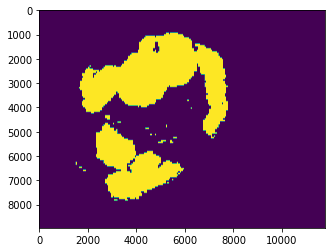

In [91]:
plt.imshow(themask)

Actual heatmap

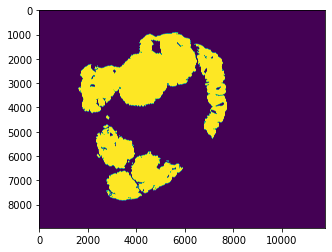

In [97]:
masks = open_slide(root_dir+"tumor_110_mask.tif")
mask_image1 = read_slide(masks, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=masks.level_dimensions[3][0], 
                        height=masks.level_dimensions[3][1])[:,:,0]
plt.imshow(mask_image1)

Predicted heatmap overlaid

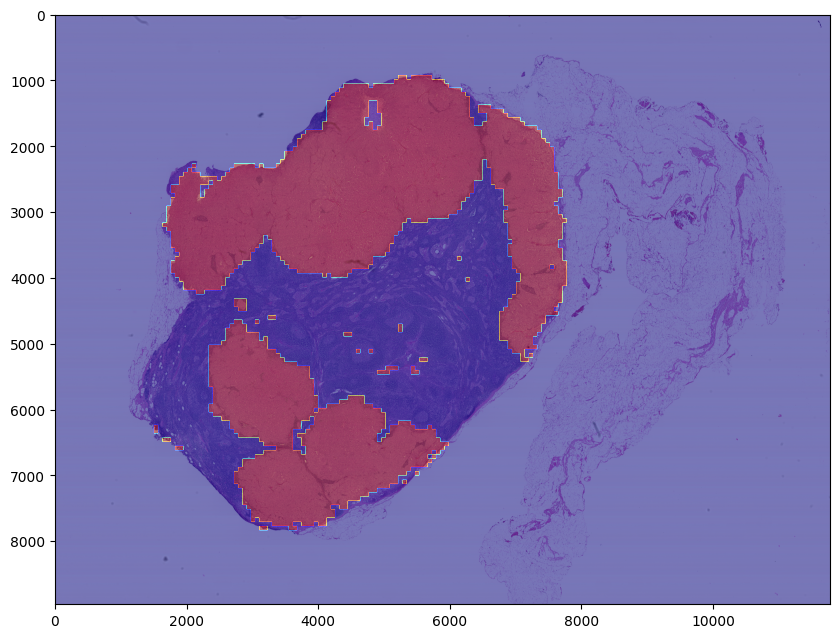

In [98]:
original_tumor = open_slide(root_dir+"tumor_110.tif")
tumor_image = read_slide(original_tumor, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=masks.level_dimensions[3][0], 
                        height=masks.level_dimensions[3][1])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tumor_image)
plt.imshow(themask, cmap='jet', alpha=0.5)

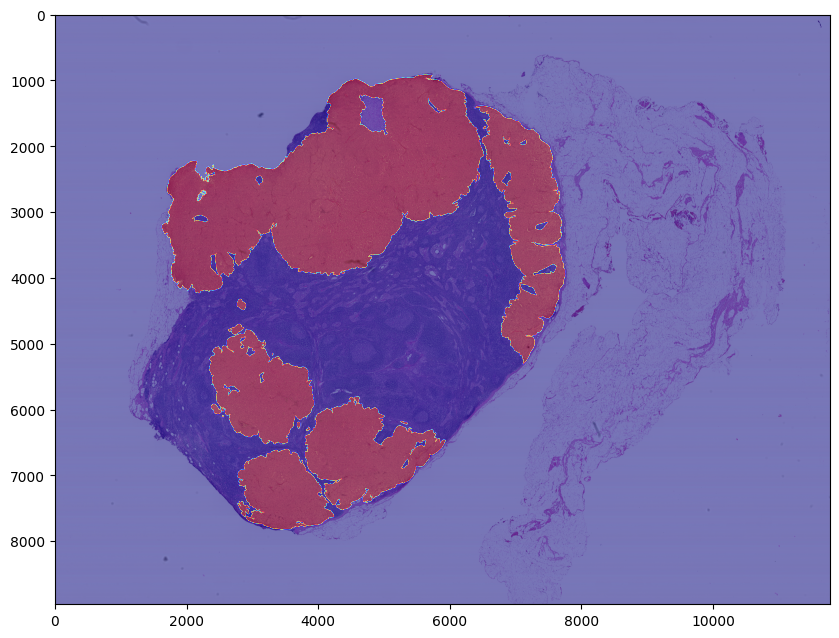

In [99]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tumor_image)
plt.imshow(mask_image1, cmap='jet', alpha=0.5)

# Evaluate the model

We will evaluate the model by comparing how many pixels match between the predicted heatmap and the actual heatmap. We will set different penalties for false positive and false negative because for medical imaging, false negative harms more than false positive. The score of a heatmap is: (number of false positive * 0.8 + number of false negative * 1.2) / total number of pixels.

In [100]:
def evaluate_model(predicted, actual):
  score = 0
  for i in range(len(predicted)):
    for j in range(len(predicted[0])):
      if predicted[i][j] == 0 and actual[i][j] == 1:
        score += 1.2
      if predicted[i][j] == 0 and actual[i][j] == 1:
        score += 1
  score /= len(predicted)*len(predicted[0])
  return 1 - score
      

Evaluations score for both training image and testing image are high and unsurprisingly, the score of traning image is slightly higher.

In [101]:
print("The score for the testing image is: ", evaluate_model(themask, mask_image1))


The score for the testing image is:  0.9921105805391542
